### Завдання
Використовуючи датасет з файлу cardox.csv (об’єми продажів мережі супермаркетів) виконайте наступну роботу:
- Проведіть попередній аналіз даних
- Скорегуйте виявлені аномалії
- Проведіть необхідні попередні підготовки даних (декомпозиція, коригування ряду, заповнення пропущених значень і. т. і.)
- Оберіть модель і проведіть оцінку її метрик
- Проведіть кінцеву діагностику для отриманої моделі
- Виконайте прогноз на 30 років
- Збережіть результати прогнозування у файл


In [50]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from adtk.data import validate_series
from adtk.visualization import plot

from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

import warnings
warnings.filterwarnings("ignore")

In [71]:
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()
    
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

In [12]:
df=pd.read_csv('https://raw.githubusercontent.com/Startup-acdm/PDS1/a62935003a6b24931bea31693f3f0be00d6f0706/Lesson%2046/cardox.csv?token=GHSAT0AAAAAAB5FDR3YWGGP4F5VFSPRFS4EZAN6T3A')
df

,date,value
0,1958-03-01,315.71
1,1958-04-01,317.45
2,1958-05-01,317.50
3,1958-06-01,317.10
4,1958-07-01,315.86
...,...,...
724,2018-07-01,408.71
725,2018-08-01,406.99
726,2018-09-01,405.51
727,2018-10-01,406.00


In [13]:
df.info('All')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    729 non-null    object 
 1   value   729 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.5+ KB


### Датасет має 729 записів та не має пропусків або нульових значень. 
### Проведемо коригування датасету для чого стовбчик date перетворимо на індекс

In [14]:
df.index = pd.to_datetime(df['date'])
df = df.drop(['date'], axis=1)
df.index

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01',
               ...
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01'],
              dtype='datetime64[ns]', name='date', length=729, freq=None)

### Візуалізуємо датасет

<AxesSubplot: xlabel='date'>

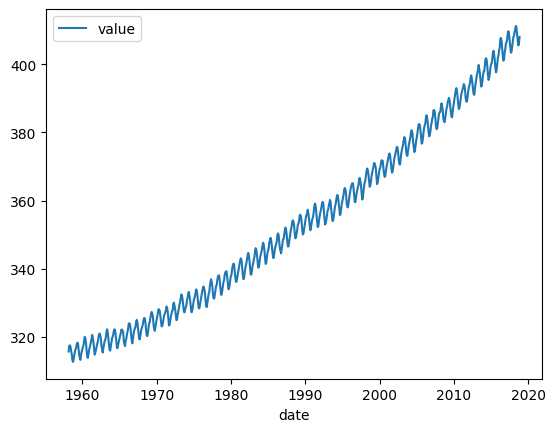

In [15]:
sns.lineplot(df)

### Проведемо аналіз ряду на стаціонарність

In [27]:
adft = adfuller(df, autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , 
                          "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                          "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0    4.994847              Test Statistics
1    1.000000                      p-value
2   20.000000             No. of lags used
3  708.000000  Number of observations used
4   -3.439620          critical value (1%)
5   -2.865631          critical value (5%)
6   -2.568948         critical value (10%)


### Можна зробити висновок що ряд не стаціонарний
### Проведемо аддітівную декомпозицію ряду

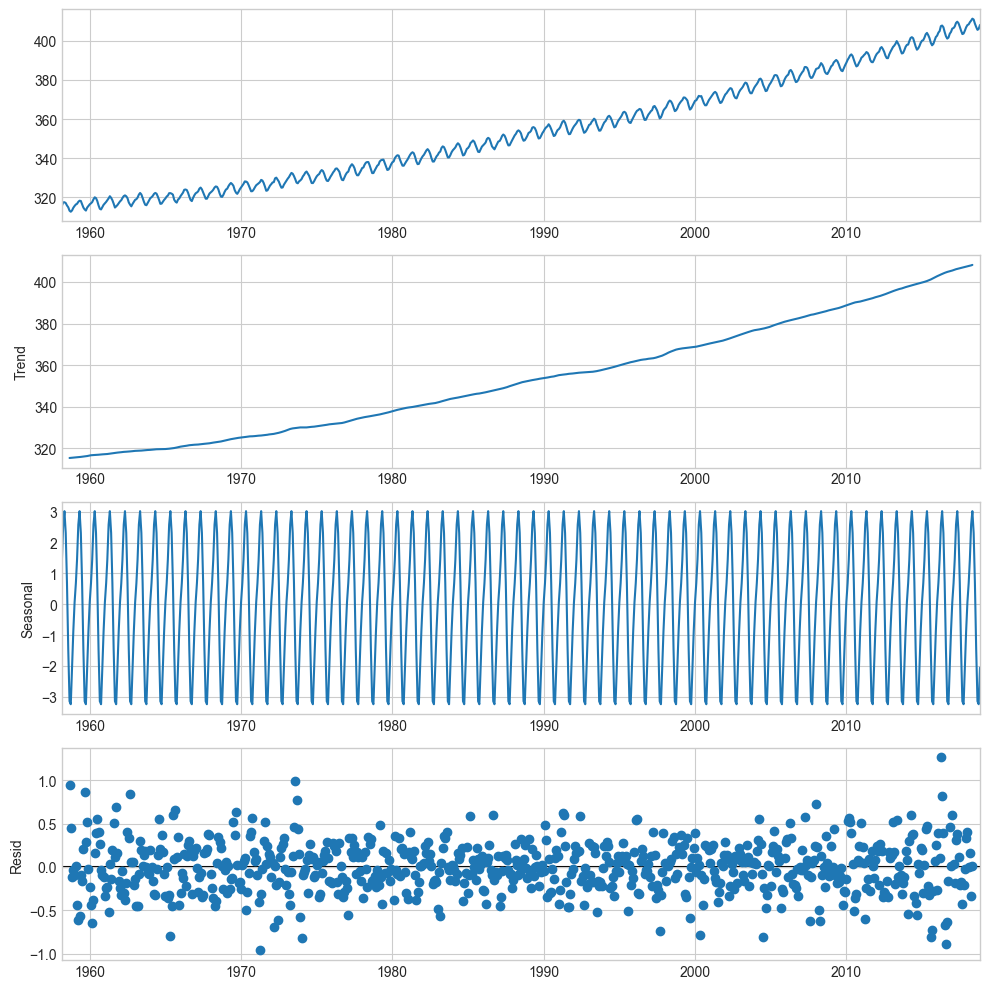

In [99]:
result_A = seasonal_decompose(df, model='additive',period=12 )
fig = result_A.plot()
plt.rcParams.update({'figure.figsize': (10,10)})
plt.show()

### Проведемо мультиплікативну декомпозицію ряду

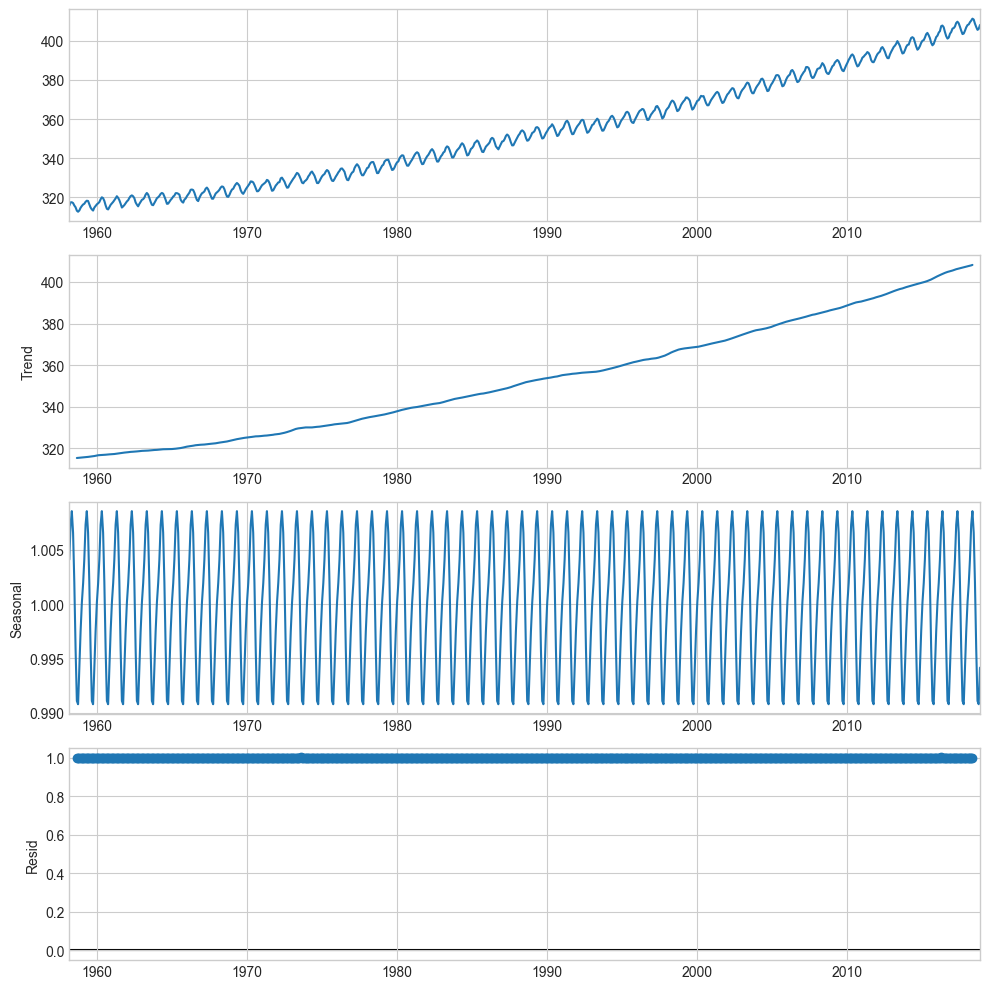

In [100]:
result_M = seasonal_decompose(df, model='multiplicative',period=12 )
fig = result_M.plot()
plt.rcParams.update({'figure.figsize': (10,10)})
plt.show()

### Ряд не має мультиплікативної складової

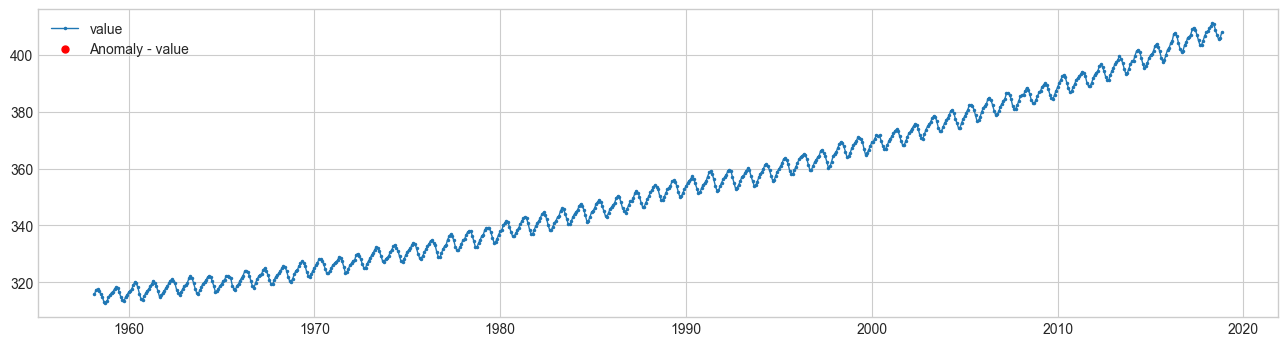

In [95]:
from adtk.detector import PersistAD
df1 = validate_series(df)
persist_ad = PersistAD(c=3.0, side='both')
anomalies = persist_ad.fit_detect(df1)
plot(df1, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

### Ряд не має аномалій

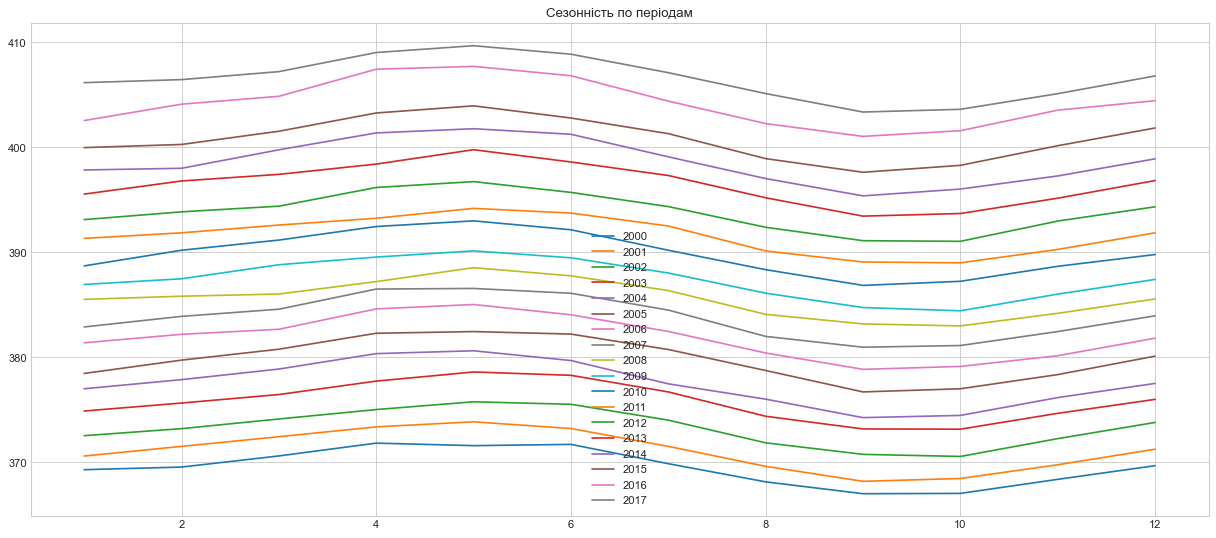

In [86]:
sesonal(df['2000':'2017'],12)


<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

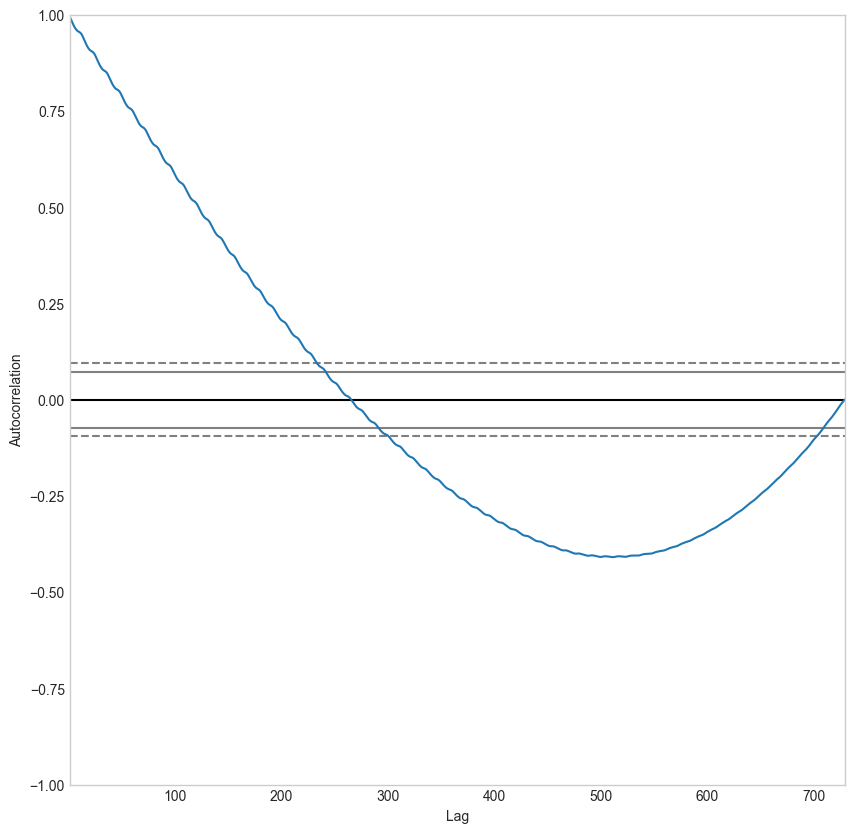

In [46]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df)

In [167]:
train = df['1958-03':'2017-01']
test = df['2017-01':'2018-11']
len(test)

23

### Побудуємо модель Хольта-Вінтерса

In [168]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()
fit1.params


{'smoothing_level': 0.6004284086411411,
 'smoothing_trend': 0.013403914216212095,
 'smoothing_seasonal': 0.06135567628220649,
 'damping_trend': nan,
 'initial_level': 315.74894260379926,
 'initial_trend': 0.07687976590003597,
 'initial_seasons': array([1.00015271, 1.00352148, 1.00489388, 1.00318004, 0.9989877 ,
        0.9930936 , 0.98821689, 0.98742199, 0.99069314, 0.99379077,
        0.99638364, 0.99823655]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [169]:
print(fit1.summary().tables[1])

                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6004284                alpha                 True
smoothing_trend               0.0134039                 beta                 True
smoothing_seasonal            0.0613557                gamma                 True
initial_level                 315.74894                  l.0                 True
initial_trend                 0.0768798                  b.0                 True
initial_seasons.0             1.0001527                  s.0                 True
initial_seasons.1             1.0035215                  s.1                 True
initial_seasons.2             1.0048939                  s.2                 True
initial_seasons.3             1.0031800                  s.3                 True
initial_seasons.4             0.9989877                  s.4                 True
initial_seasons.

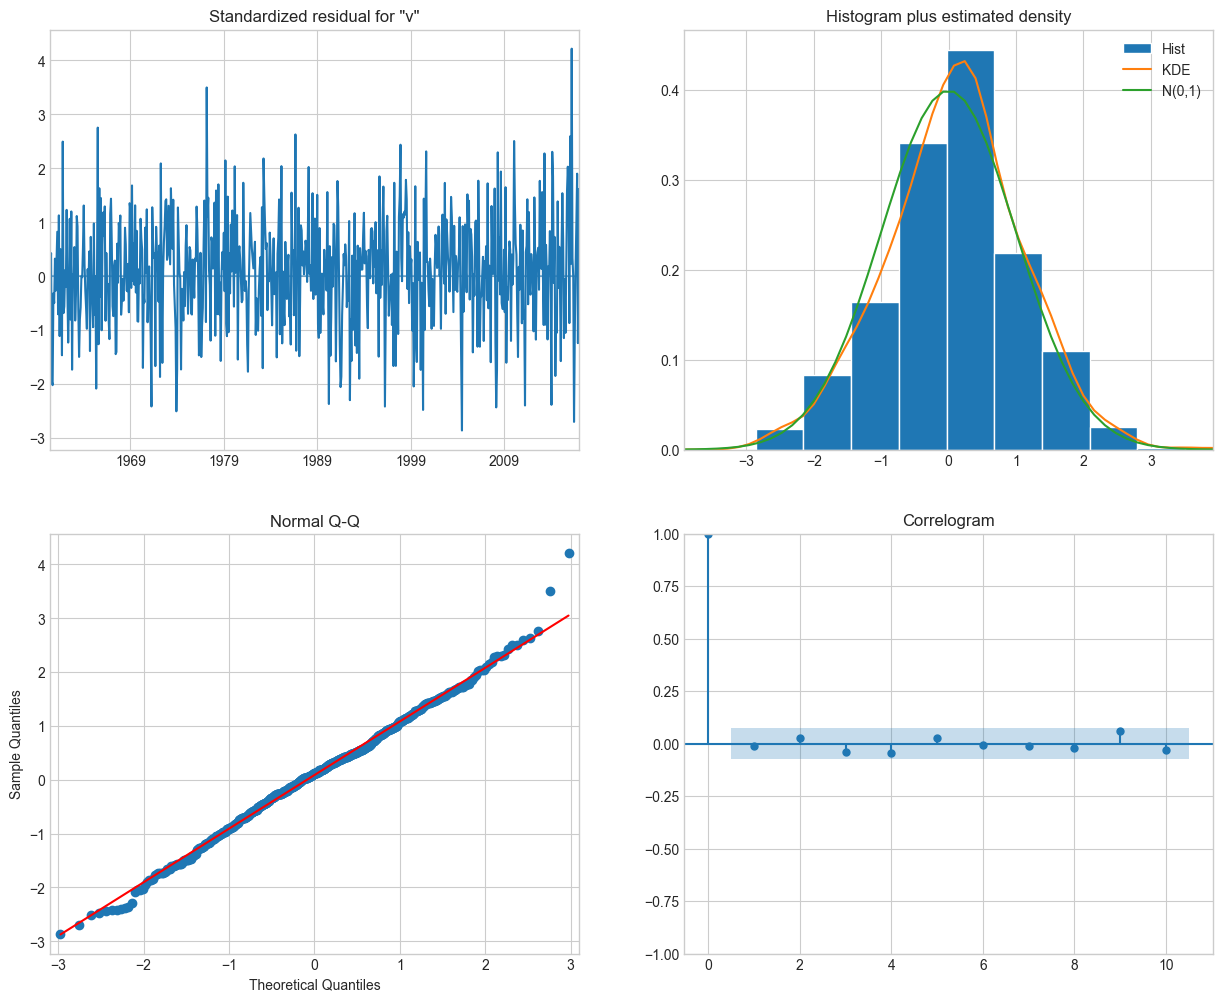

In [179]:
y=fit1.forecast(22)

results.plot_diagnostics(figsize=(15, 12))
plt.show()

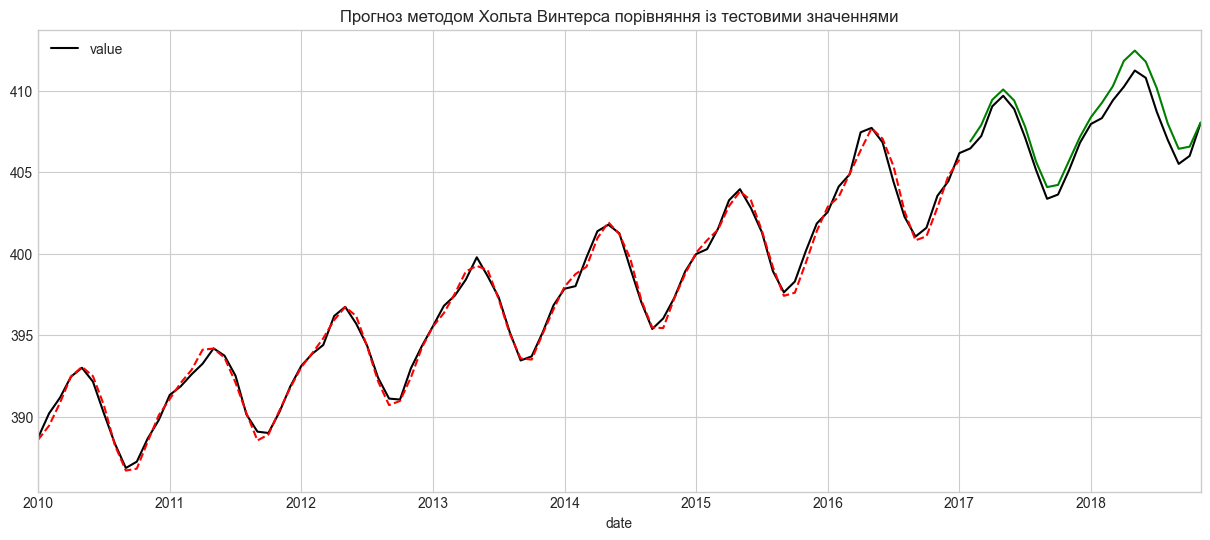

In [171]:
ax = df['2010':].plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса порівняння із тестовими значеннями" )
fit1.fittedvalues['2010':].plot(ax=ax, style='--', color='red')
y.plot(ax=ax,  color='green')
plt.show()

In [175]:
metrics(test, fit1.forecast(23))


Тест на стаціонарність:
	T-статистика = -3.504
	P-значення = 0.008
Критичне значення :
	1%: -4.068853732362312 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -3.1271488757396453 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.7017297633136095 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 1.3396
MSE: 2.1843
MAPE: 0.0033
MPE: -0.0021
Стандартна похибка: 1.4779


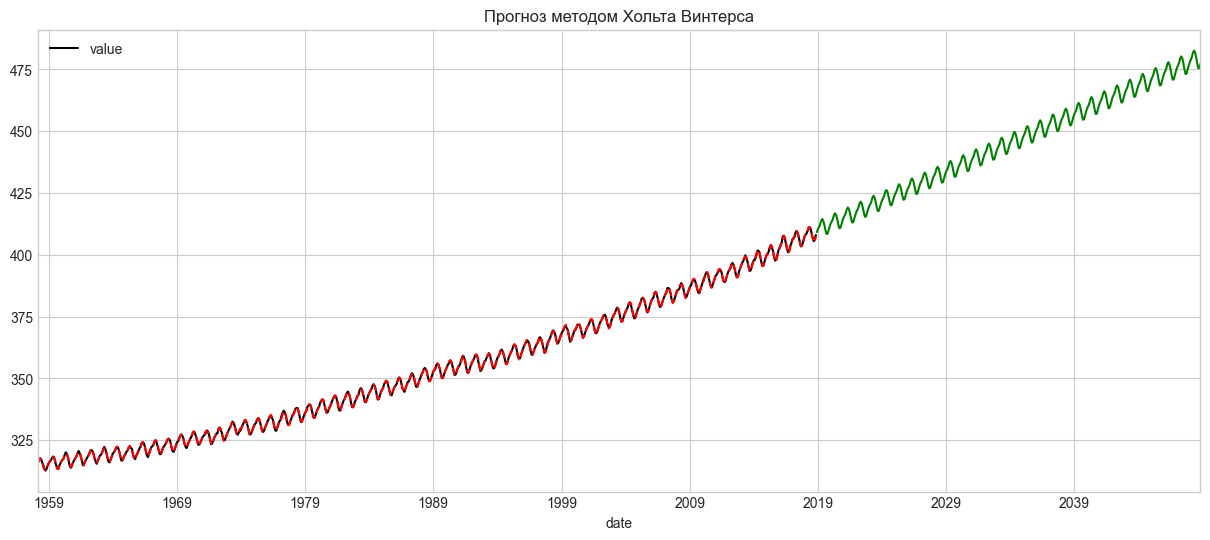

In [176]:
fit1 = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='mul').fit()
ax = df[:].plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Винтерса" )
fit1.fittedvalues[:].plot(ax=ax, style='--', color='red')
fit1.forecast(360).plot(ax=ax,  color='green')
plt.show()


In [216]:
metrics(df, fit1.fittedvalues)

Тест на стаціонарність:
	T-статистика = -15.232
	P-значення = 0.000
Критичне значення :
	1%: -3.4394018678958544 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.865534780932388 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.5688972751486325 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.2406
MSE: 0.0955
MAPE: 0.0007
MPE: 0.0001
Стандартна похибка: 0.3091


### Побудуємо модель SARIMAX

In [177]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 
aic_res=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results = mod.fit()
            aic_res.append(results.aic)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
print('Min AIC = ', min(aic_res))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:10289.559927328508
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10130.463401158959
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2724.694483647322
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2302.329967786335
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1485.637482870156
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1482.3044397257959
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1806.0794357505001
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1315.537772301066
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:9307.406962409288
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8251.909407187937
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2026.290359454987
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1815.2824724099228
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1115.729008829515
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1108.2374776837798
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1525.8834581587146
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1018.9249642270263
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2295.908957160214
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1697.7568057124438
A

In [199]:
mod = sm.tsa.statespace.SARIMAX(train,
order=(1, 1, 1),
seasonal_order=(1, 1, 1, 12),
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1736      0.085      2.039      0.041       0.007       0.340
ma.L1         -0.5367      0.075     -7.185      0.000      -0.683      -0.390
ar.S.L12      -0.0005      0.000     -1.617      0.106      -0.001       0.000
ma.S.L12      -0.8649      0.023    -38.278      0.000      -0.909      -0.821
sigma2         0.0944      0.005     20.029      0.000       0.085       0.104


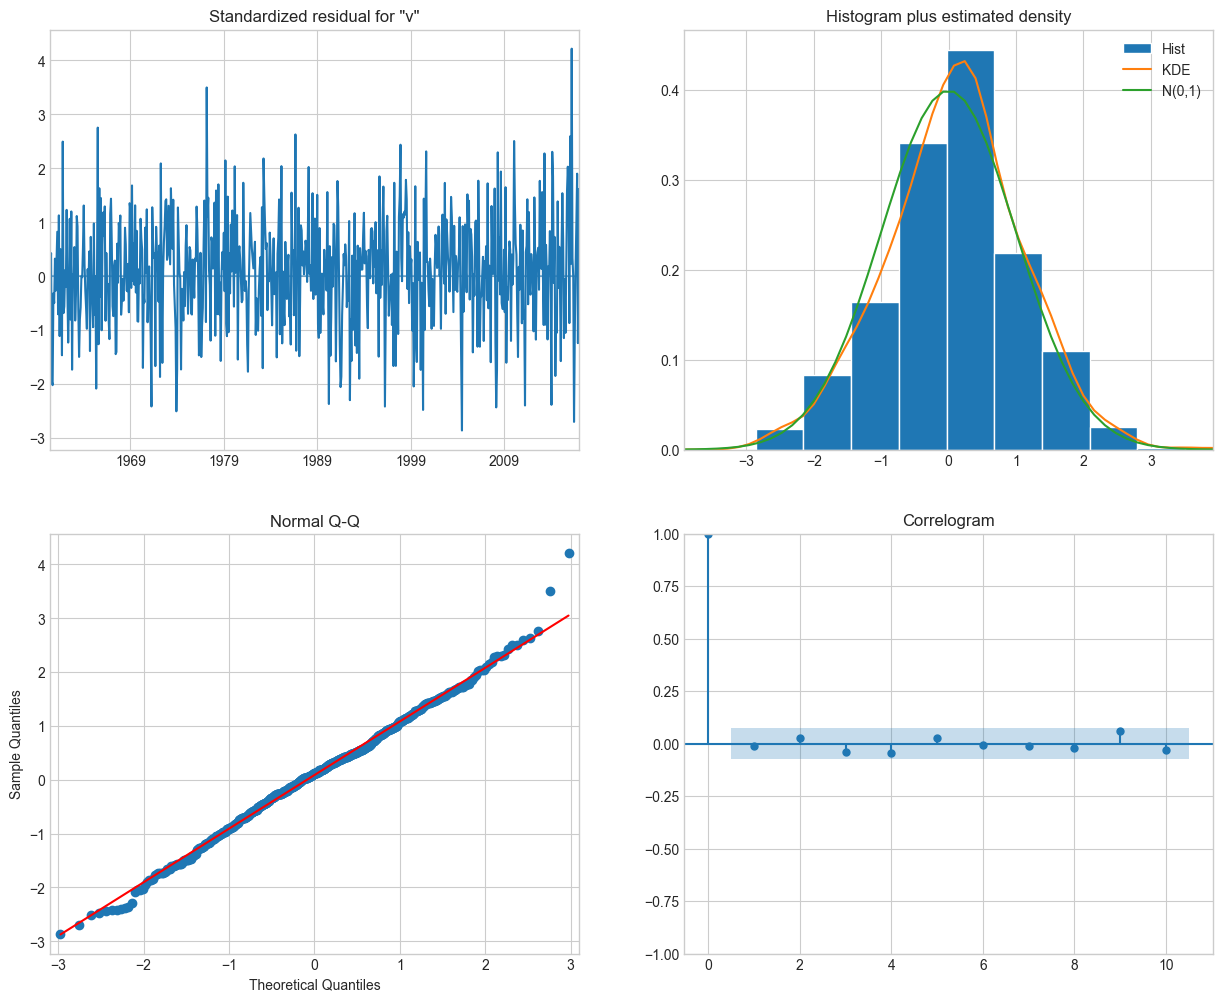

In [181]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [200]:
metrics(train,results.fittedvalues)

Тест на стаціонарність:
	T-статистика = -51.269
	P-значення = 0.000
Критичне значення :
	1%: -3.439646367660705 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.8656425177031375 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.5689546724554404 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 1.0516
MSE: 204.3114
MAPE: 0.0032
MPE: 0.0006
Стандартна похибка: 14.2938


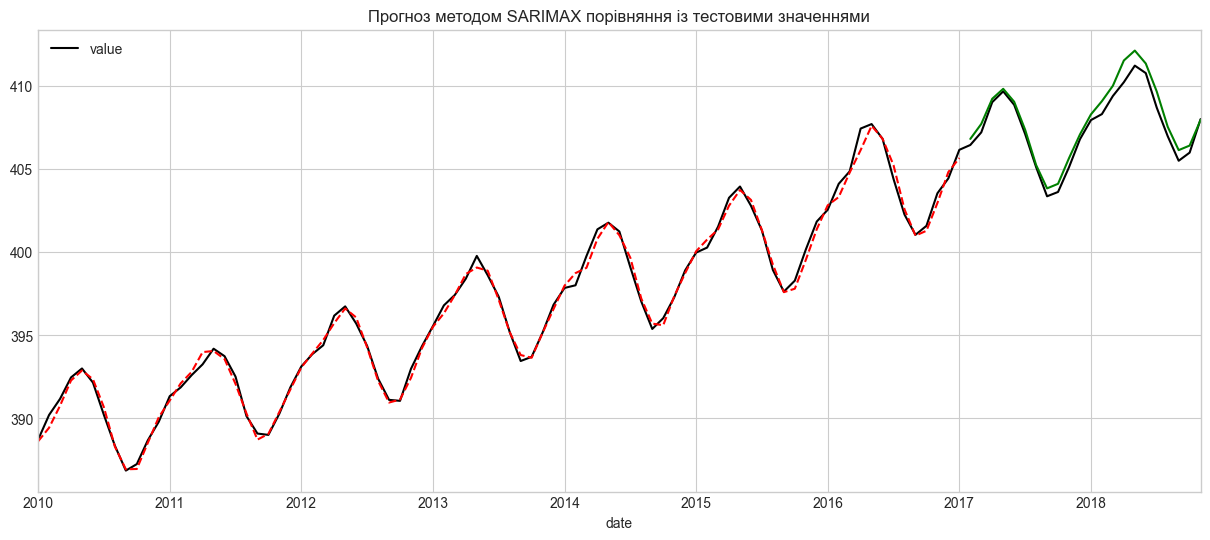

In [201]:
y=results.forecast(22)
ax = df['2010':].plot(figsize=(15,6), color='black', title="Прогноз методом SARIMAX порівняння із тестовими значеннями" )
results.fittedvalues['2010':].plot(ax=ax, style='--', color='red')
y.plot(ax=ax,  color='green')
plt.show()

In [202]:
y_truth = df['value']['2017-01-01':] 
mse = ((y - y_truth) ** 2).mean()
print('Середня квадратична похибка на тестовій виборці = {}'.format(round(mse, 2)))

Середня квадратична похибка на тестовій виборці = 0.33


### Проведемо навчання моделі на повній виборці та зробимо прогноз на 30 років

In [208]:
mod = sm.tsa.statespace.SARIMAX(df,
order=(1, 1, 1),
seasonal_order=(1, 1, 1, 12),
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1707      0.084      2.038      0.042       0.007       0.335
ma.L1         -0.5360      0.073     -7.307      0.000      -0.680      -0.392
ar.S.L12      -0.0005      0.000     -1.624      0.104      -0.001    9.83e-05
ma.S.L12      -0.8671      0.021    -41.952      0.000      -0.908      -0.827
sigma2         0.0941      0.005     20.328      0.000       0.085       0.103


In [209]:
y=results.forecast(360)

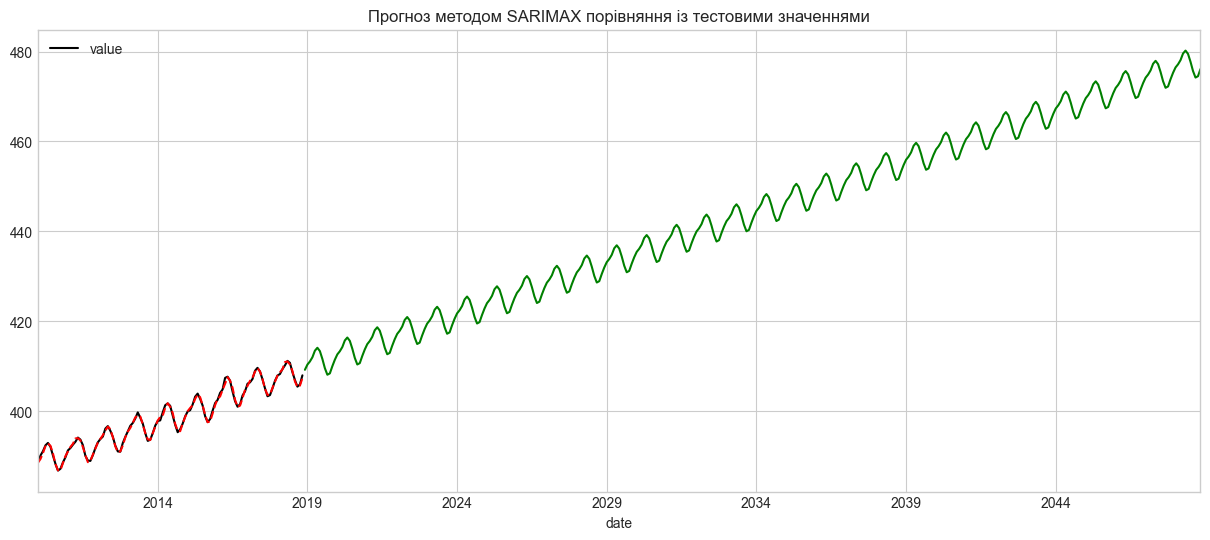

In [210]:

ax = df['2010':].plot(figsize=(15,6), color='black', title="Прогноз методом SARIMAX порівняння із тестовими значеннями" )
results.fittedvalues['2010':].plot(ax=ax, style='--', color='red')
y.plot(ax=ax,  color='green')
plt.show()

In [211]:
metrics(df,results.fittedvalues)

Тест на стаціонарність:
	T-статистика = -52.000
	P-значення = 0.000
Критичне значення :
	1%: -3.4393644334758475 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.8655182850048306 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.568888486973192 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 1.0257
MSE: 198.1215
MAPE: 0.0032
MPE: 0.0005
Стандартна похибка: 14.0756


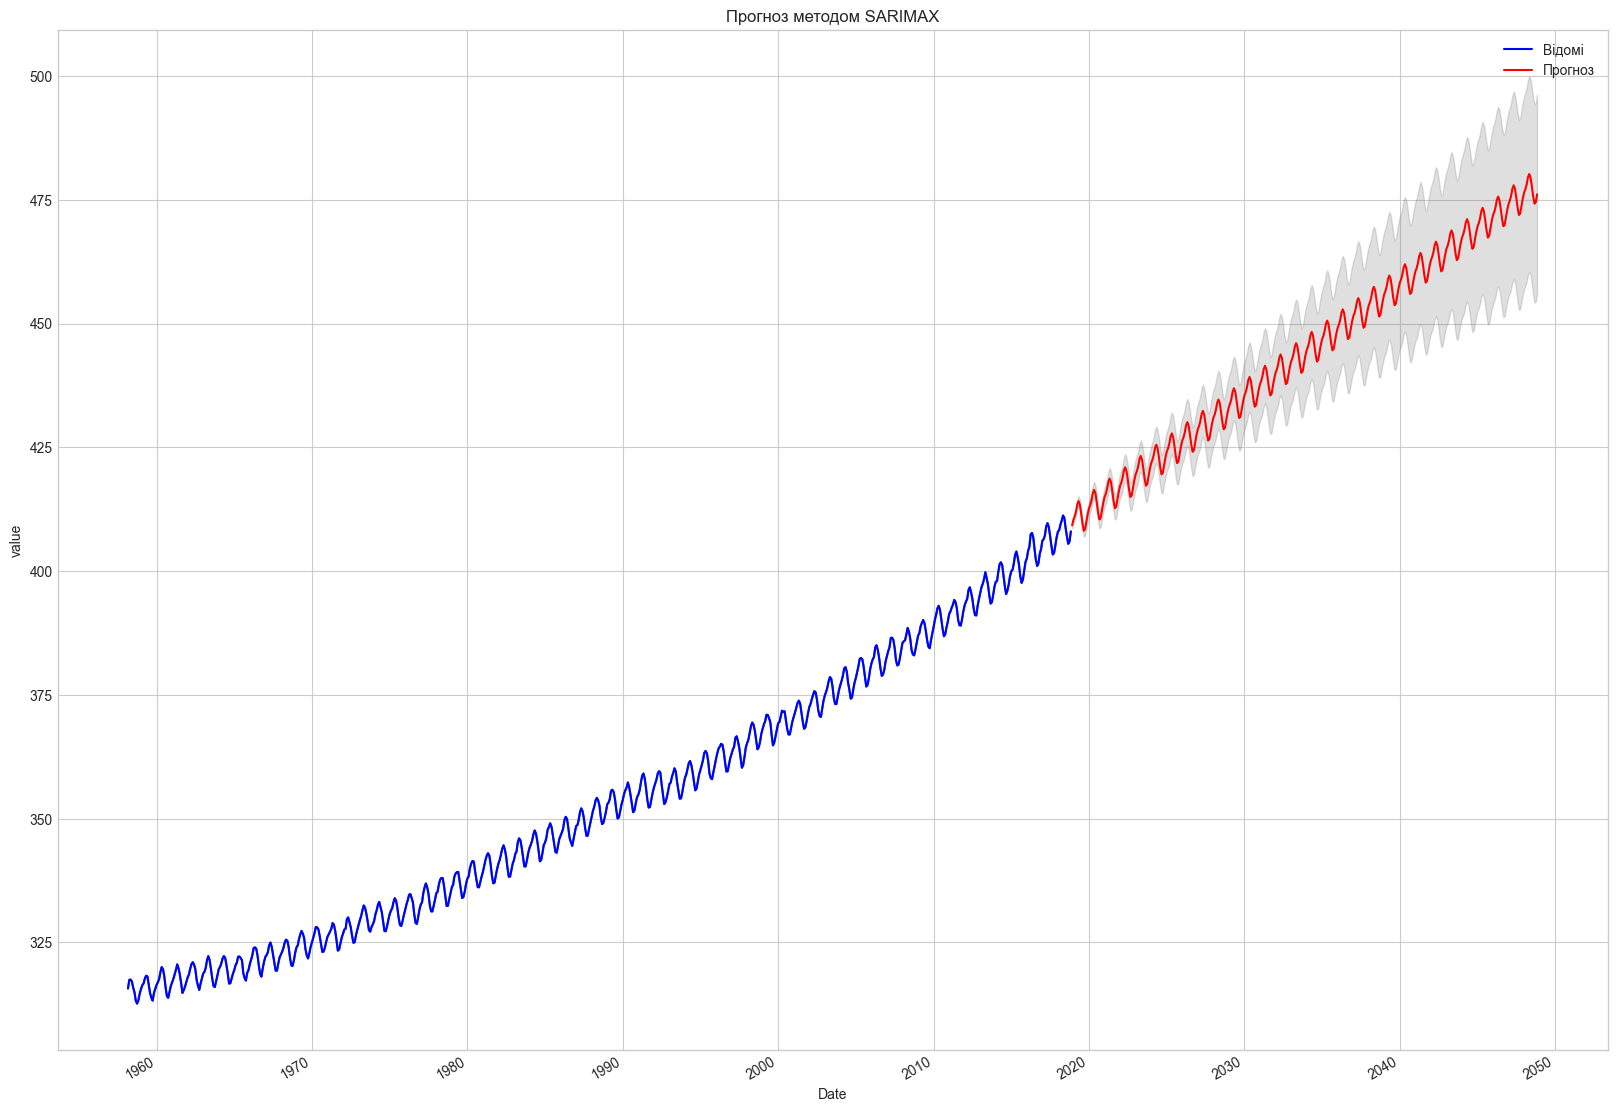

In [213]:
pred_uc = results.get_forecast(steps=360)
pred_ci = pred_uc.conf_int()

plt.plot(df['value'])
ax = df['value'][:].plot(label='Відомі', figsize=(20, 15),color='blue')
pred_uc.predicted_mean.plot(ax=ax, label='Прогноз',color='red')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='grey', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('value')
ax.set_title('Прогноз методом SARIMAX')
plt.legend()
plt.show()

### Висновки
### Метод Хольта-Вінтерса показує кращі результати на повному  датафреймі але гірші результати на тестовій виборці. В цілому показники обох методів прийнятні для прогнозування.